In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728232916.105599      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1006 16:41:56.113406933      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1006 16:41:56.113420818      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1006 16:41:56.113424187      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1006 16:41:56.113426632      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1006 16:41:56.113429088      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [3]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape)
print(y_train.shape)

(7116, 512, 1024, 3)
(7116, 2)


In [4]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728233028.322919      13 service.cc:145] XLA service 0x5b2c50462720 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728233028.322977      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728233028.322981      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728233028.322984      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728233028.322988      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728233028.322991      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728233028.322995      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728233028.322997      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728233028.323000      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728233033.403633      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 16, 32, 2048)   │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,178 (223.52 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=16,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-ResNet152V2_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-06 16:46:58.024862: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728233220.319862     820 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b1a8bebabb63991c:0:0), session_name()


  1/445 ━━━━━━━━━━━━━━━━━━━━ 3:33:30 29s/step - accuracy: 0.5000 - loss: 1.1326

I0000 00:00:1728233236.573172     820 tpu_compile_op_common.cc:245] Compilation of b1a8bebabb63991c:0:0 with session name  took 16.253202904s and succeeded
I0000 00:00:1728233236.600295     820 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b1a8bebabb63991c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16093562984962817134", property.function_library_fingerprint = 6305597242407931035, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728233236.600354     820 tpu_compilation_cache_interface.cc:541] After adding entry for key

445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5783 - loss: 0.6819

2024-10-06 16:48:27.461137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728233308.982618     806 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(19e7e62bb8c9c06a:0:0), session_name()
I0000 00:00:1728233323.604383     806 tpu_compile_op_common.cc:245] Compilation of 19e7e62bb8c9c06a:0:0 with session name  took 14.621710191s and succeeded
I0000 00:00:1728233323.626948     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(19e7e62bb8c9c06a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11878860378294388382", property.function_library_fingerprint = 9666792639118013371, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

445/445 ━━━━━━━━━━━━━━━━━━━━ 126s 218ms/step - accuracy: 0.5784 - loss: 0.6818 - val_accuracy: 0.6009 - val_loss: 0.6570
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.6489 - loss: 0.5980 - val_accuracy: 0.6457 - val_loss: 0.6432
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.6745 - loss: 0.6040 - val_accuracy: 0.6682 - val_loss: 0.6400
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.6966 - loss: 0.5855 - val_accuracy: 0.6682 - val_loss: 0.6267
Epoch 5/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.6738 - loss: 0.5899 - val_accuracy: 0.6323 - val_loss: 0.6478
Epoch 6/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.7152 - loss: 0.5698 - val_accuracy: 0.6816 - val_loss: 0.6151
Epoch 7/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.7099 - loss: 0.5603 - val_accuracy: 0.6637 - val_loss: 0.6101
Epoch 8/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.6807 - loss: 0.58

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [7]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728236220.969926     786 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(173fd0861f413eec:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 13:06 14s/step - accuracy: 0.7500 - loss: 0.4647

I0000 00:00:1728236234.257331     786 tpu_compile_op_common.cc:245] Compilation of 173fd0861f413eec:0:0 with session name  took 13.287303169s and succeeded
I0000 00:00:1728236234.280797     786 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(173fd0861f413eec:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11878860378294388382", property.function_library_fingerprint = 9666792639118013371, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728236234.280845     786 tpu_compilation_cache_interface.cc:541] After adding entry for key

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7391 - loss: 0.5490

I0000 00:00:1728236241.768597     763 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(829138394056394d:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.7385 - loss: 0.5499


I0000 00:00:1728236255.446643     763 tpu_compile_op_common.cc:245] Compilation of 829138394056394d:0:0 with session name  took 13.67800382s and succeeded
I0000 00:00:1728236255.475563     763 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(829138394056394d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11878860378294388382", property.function_library_fingerprint = 9666792639118013371, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728236255.475592     763 tpu_compilation_cache_interface.cc:541] After adding entry for key 

Test accuracy: 72.20%


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-06 17:40:21.384104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728236422.516593     813 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8875214ddf864516:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 17:44 19s/step

I0000 00:00:1728236434.639991     813 tpu_compile_op_common.cc:245] Compilation of 8875214ddf864516:0:0 with session name  took 12.123351893s and succeeded
I0000 00:00:1728236434.671304     813 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8875214ddf864516:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14273512680504373275", property.function_library_fingerprint = 7658907042099499291, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728236434.671357     813 tpu_compilation_cache_interface.cc:541] After adding entry for key 8875214ddf

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step

I0000 00:00:1728236459.638536     761 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(98189342f2e37e87:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 716ms/step


I0000 00:00:1728236474.024991     761 tpu_compile_op_common.cc:245] Compilation of 98189342f2e37e87:0:0 with session name  took 14.386408816s and succeeded
I0000 00:00:1728236474.054006     761 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(98189342f2e37e87:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11266526919011834425", property.function_library_fingerprint = 4160606269833423488, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728236474.054052     761 tpu_compilation_cache_interface.cc:541] After adding entry for 

Accuracy: 0.748314606741573
Precision: 0.7483155344524808
Recall: 0.7483130265282496
F1 Score: 0.748313335757282
Number of Epochs: 61
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step


<Figure size 1600x1600 with 0 Axes>

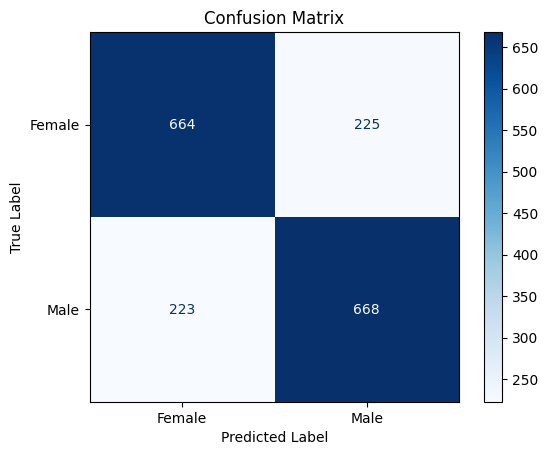

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

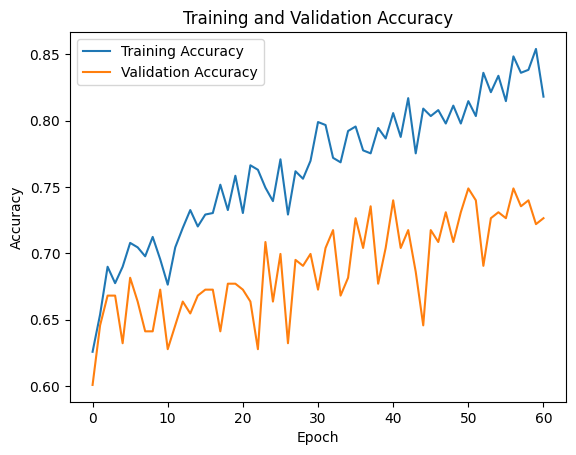

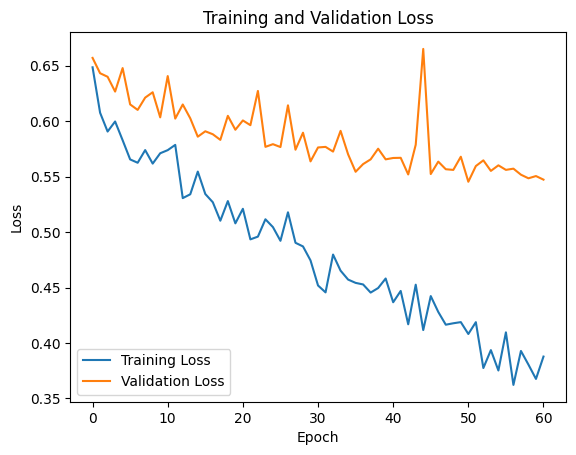

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()